# Fine Tune BERT Sequence Classification Model

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertModel, DistilBertTokenizer, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam
import time
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('unvectorized_Human_AI_50k.csv')

In [ ]:
df.head()

,text,generated
0,Climate Change has become one of the most talk...,1
1,Public schools are not always the best to atte...,0
2,Should summer projects be designed by students...,0
3,The meaning of an democracy is that the people...,0
4,Limiting Car Usage Has Many Advantages Cars ar...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       49998 non-null  object
 1   generated  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49998 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       49998 non-null  object
 1   generated  49998 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# Train Test Split, similar to other model implementation

In [ ]:
X = df['text']
y = df['generated']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)  # 75% training, 25% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)  # 60% of temp for test, 40% for validation

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
train_tokens = tokenizer(list(X_train), padding=True, truncation=True)
validation_tokens = tokenizer(list(X_val), padding=True, truncation=True)
test_tokens = tokenizer(list(X_test), padding=True, truncation=True)

# Tokenize Data

In [ ]:
class TokenData(Dataset):
    def __init__(self, split='train'):
        if split == 'train':
            self.text_data = X_train
            self.tokens = train_tokens
            self.labels = list(y_train)
        elif split == 'val':
            self.text_data = X_val
            self.tokens = validation_tokens
            self.labels = list(y_val)
        elif split == 'test':
            self.text_data = X_test
            self.tokens = test_tokens
            self.labels = list(y_test)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
      try:
          sample = {}
          for k, v in self.tokens.items():

              sample[k] = torch.tensor(v[idx])
          sample['labels'] = torch.tensor(self.labels[idx])
          return sample
      except IndexError:
          print(f"IndexError at idx: {idx}")
          raise

In [ ]:
batch_size = 16
train_dataset = TokenData(split= 'train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

validation_dataset = TokenData(split= 'val')
validation_loader = DataLoader(validation_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TokenData(split = 'test')
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# Create Custom Bert Model for Classification

In [ ]:
class DistilBertClassifier(torch.nn.Module):
    def __init__(self, distilbert):
        super(DistilBertClassifier, self).__init__()
        self.distilbert = distilbert
        self.classifier = torch.nn.Linear(distilbert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token embedding
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Freeze DistilBERT parameters
for param in distilbert.parameters():
    param.requires_grad = False

# Initialize model, loss function, and optimizer
model = DistilBertClassifier(distilbert).to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = AdamW(model.classifier.parameters(), lr=1e-4)

Epoch 1/15
Training loss: 0.4504
Validation loss: 0.3550, Validation accuracy: 0.8630
Epoch 2/15
Training loss: 0.3212
Validation loss: 0.2950, Validation accuracy: 0.8914
Epoch 3/15
Training loss: 0.2753
Validation loss: 0.2671, Validation accuracy: 0.9006
Epoch 4/15
Training loss: 0.2483
Validation loss: 0.2433, Validation accuracy: 0.9126
Epoch 5/15
Training loss: 0.2287
Validation loss: 0.2283, Validation accuracy: 0.9190
Epoch 6/15
Training loss: 0.2139
Validation loss: 0.2186, Validation accuracy: 0.9202
Epoch 7/15
Training loss: 0.2026
Validation loss: 0.2022, Validation accuracy: 0.9298
Epoch 8/15
Training loss: 0.1937
Validation loss: 0.1972, Validation accuracy: 0.9298
Epoch 9/15
Training loss: 0.1859
Validation loss: 0.1967, Validation accuracy: 0.9274
Epoch 10/15
Training loss: 0.1788
Validation loss: 0.1828, Validation accuracy: 0.9344
Epoch 11/15
Training loss: 0.1735
Validation loss: 0.1761, Validation accuracy: 0.9374
Epoch 12/15
Training loss: 0.1678
Validation loss: 0

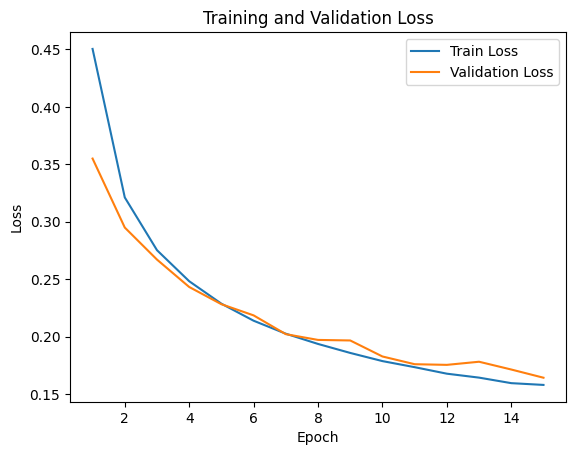

In [ ]:
# Training and validation loop
num_epochs = 15
train_losses = []
val_losses = []

start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move data to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()  # Ensure labels are float for BCEWithLogitsLoss

        # Forward pass
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Training loss: {avg_train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in validation_loader:
            # Move data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            # Forward pass
            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits.squeeze(-1), labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = (torch.sigmoid(logits) > 0.5).long().squeeze(-1)
            correct_predictions += (predictions == labels.long()).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_predictions / total_predictions
    print(f"Validation loss: {avg_val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

# Plot losses (optional)
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

model.eval()

# Lists to store predictions and true labels
all_predictions = []
all_labels = []

# Disable gradient calculation for testing (faster and less memory usage)
with torch.no_grad():
    for batch in test_loader:  # Assuming test_loader is defined
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).float()

        # Forward pass through the model
        logits = model(input_ids=input_ids, attention_mask=attention_mask)

        # Apply sigmoid and threshold for binary classification (0 or 1)
        predictions = (torch.sigmoid(logits) > 0.5).long().squeeze(-1)

        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the classification report
report = classification_report(all_labels, all_predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      3704
         1.0       0.93      0.96      0.95      3796

    accuracy                           0.95      7500
   macro avg       0.95      0.95      0.95      7500
weighted avg       0.95      0.95      0.95      7500

